In [1]:
# settings
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import lsdb
# from lsdb import dask
import hipscat
import dask
from dask.distributed import Client
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.pipeline import pipeline_with_client
from hipscat.io import write_metadata
from hipscat.inspection import plot_points
import ray
from ray.util.dask import enable_dask_on_ray, disable_dask_on_ray
import os
from pathlib import Path
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [2]:
# to make sure epyc is safe from me
dask.config.set({'temporary_directory': '/astro/users/juliexue/root/users/juliexue/tmp'})

client = ray.init(
    num_cpus = 4
)
enable_dask_on_ray()

2024-03-24 23:53:15,875	INFO worker.py:1724 -- Started a local Ray instance.
/astro/users/juliexue/.conda/envs/python_3.10/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'shuffle' has been deprecated; please use 'dataframe.shuffle.algorithm' instead
  warnings.warn(


In [3]:
# imports
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")

mage_data_dir = "/astro/users/juliexue/mydata/mage_bonaca_rcat_V0.05.fits"
output_dir = "/astro/users/juliexue/mydata"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
import os
import pyarrow.parquet as pq
import tempfile

tmp_path = tempfile.TemporaryDirectory()
sample_parquet_file = os.path.join(tmp_path.name, "sample.parquet")

from hipscat_import.catalog.file_readers import FitsReader

### Change this path!!!
input_file = "/astro/users/juliexue/mydata/mage_bonaca_rcat_V0.05.fits"

file_reader = FitsReader(chunksize=5_000)

next(file_reader.read(input_file)).to_parquet(sample_parquet_file)

sample_file_size = os.path.getsize(sample_parquet_file)
parquet_file = pq.ParquetFile(sample_parquet_file)
num_rows = parquet_file.metadata.num_rows

## 100MB
ideal_file_small = 100 * 1024 * 1024
## 800MB
ideal_file_large = 800 * 1024 * 1024

threshold_small = ideal_file_small / sample_file_size * num_rows
threshold_large = ideal_file_large / sample_file_size * num_rows

print(f"threshold between {int(threshold_small):_} and {int(threshold_large):_}")

threshold between 34_841 and 278_729


In [5]:
%%time
args = ImportArguments(
    output_artifact_name="MagE_hipscat",
#    input_path="~/mydata/DELVE_dr1_area_selection_gr",
    input_format="fits",
    input_file_list=["~/mydata/mage_bonaca_rcat_V0.05.fits"],
    ra_column="GAIAEDR3_RA",
    dec_column="GAIAEDR3_DEC",
#    id_column="source_id",
    output_path=output_dir,
    dask_tmp="/astro/users/juliexue/root/users/juliexue/tmp",
    tmp_dir="/astro/users/juliexue/root/users/juliexue/tmp",
#    use_schema_file=f"{Path.home()}/mydata/DELVE_metadata",
#    manual_dtypes={'libname_gspphot':'unicode'},
    pixel_threshold=500_000,
    highest_healpix_order=5,
    overwrite=True
)

Planning  : 100%|██████████| 5/5 [00:00<00:00, 939.46it/s]

tmp_path (/astro/users/juliexue/root/users/juliexue/tmp/MagE_hipscat/intermediate) contains intermediate files. resuming prior progress.
CPU times: user 11.6 ms, sys: 6.31 ms, total: 17.9 ms
Wall time: 34.5 ms


In [6]:
mage = Table.read(mage_data_dir, format='fits')
df = mage.to_pandas()
#print(list(df.columns.values))

In [7]:
%%time
with Client( 
    local_directory=args.dask_tmp,
    n_workers=4
) as client:
    pipeline_with_client(args, client)

Binning   :  50%|█████     | 1/2 [01:42<01:42, 102.43s/it]


ValueError: histogram is not the right size

/astro/users/juliexue/.conda/envs/python_3.10/lib/python3.10/site-packages/hipscat/catalog/partition_info.py:138: UserWarning: Reading partitions from parquet metadata. This is typically slow.
  warnings.warn("Reading partitions from parquet metadata. This is typically slow.")


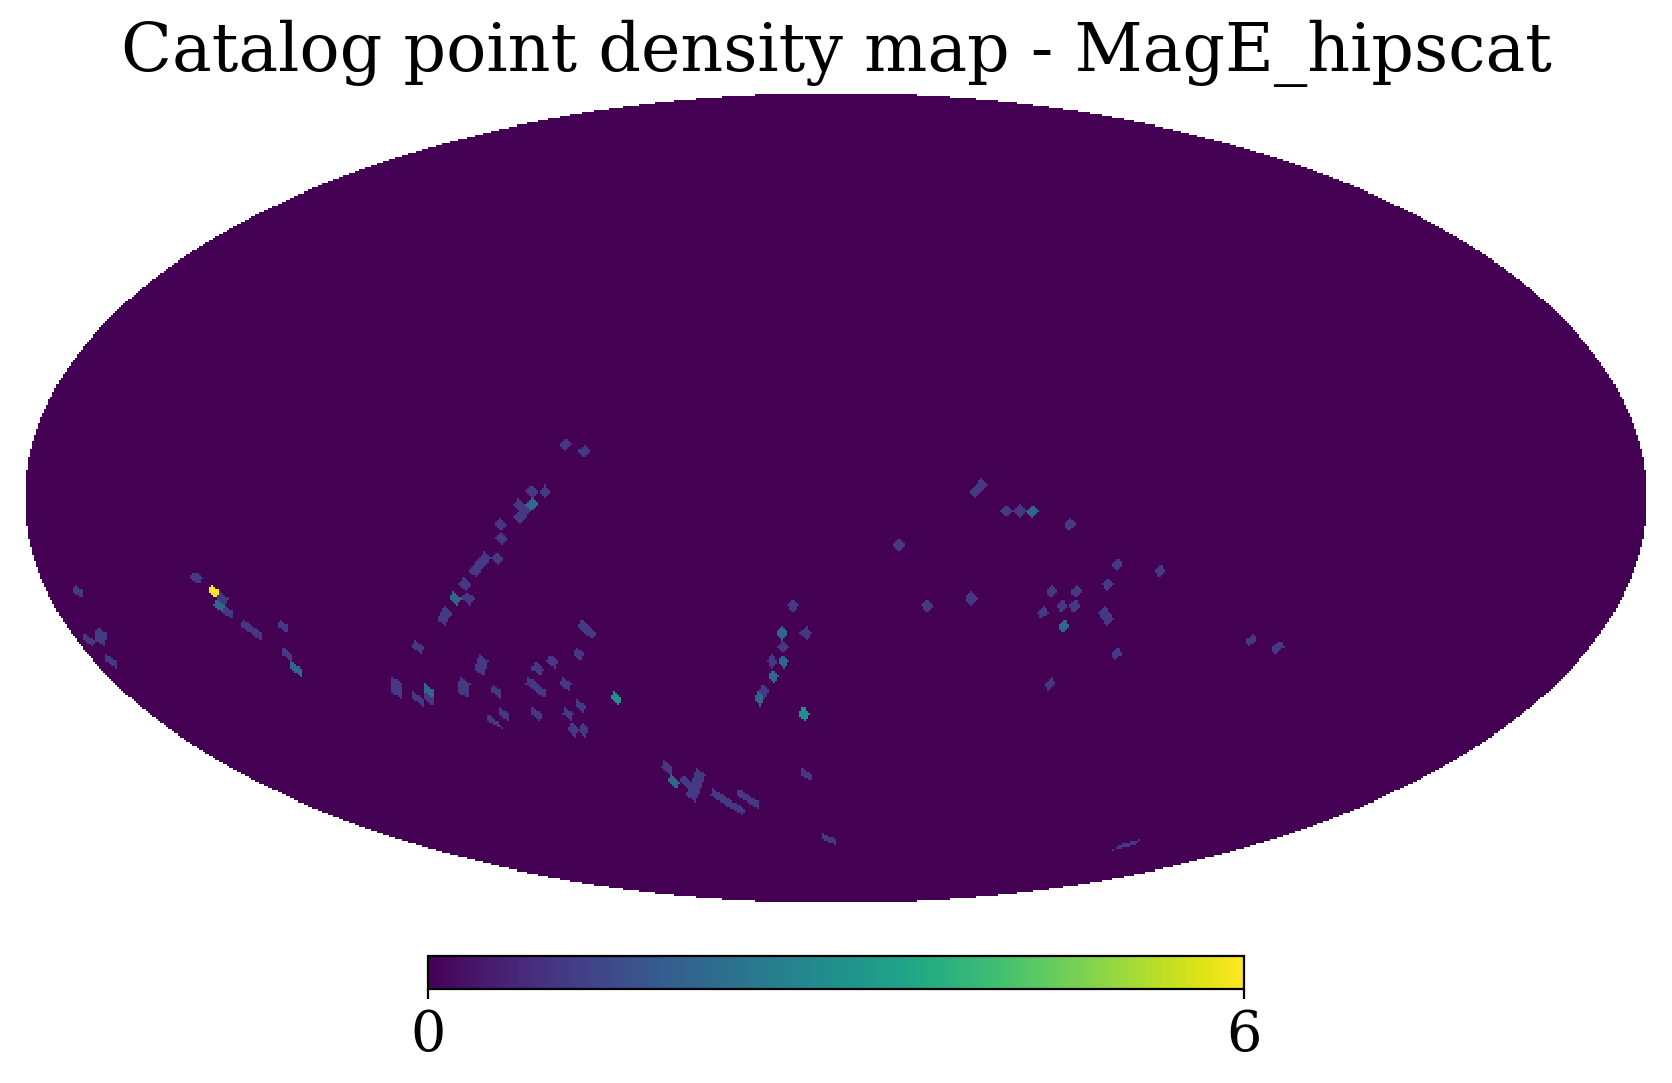

In [33]:
# check output file
magehips = lsdb.read_hipscat(output_dir+"/MagE_hipscat")
plot_points(magehips.hc_structure)

In [ ]:
%%time
# join
joined = magehips.join(gaia, left_on="GAIAEDR3_ID", right_on="source_id", suffixes=["","_GAIADR3"]
).compute()
joined

In [5]:
disable_dask_on_ray()
ray.shutdown()

In [30]:
%%time
# lets try crossmatching it
xmatch_test = magehips.crossmatch(gaia, radiusarcsec=0.5, suffixes=["","_GAIADR3"]
).compute()
xmatch_test

NameError: name 'magehips' is not defined